# MODEL

In [76]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
import enum

import os
from PIL import Image
import cv2 #pip install opencv-python
import torchvision.transforms as transforms
import matplotlib.image as mpimg
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50
from torchvision import datasets, models, transforms
import torchvision
import copy
import sklearn.metrics
import time
import torch.utils
import torch.utils.data
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

Reeee

In [94]:
import import_ipynb
# import proeprocess
%run preprocess.ipynb
%run stinna.ipynb

In [20]:
simple_transformer = transforms.Compose([
        transforms.ToTensor()])

Split data into train set, validation set and test set with ratio 80/10/10

In [22]:
# import splitfolders
# splitfolders.ratio(PATHbirdsWithBackground, output="output",seed=42, ratio=(0.8,0.1,0.1) )

Set up paths to data and dataloaders for traning set and validation set

In [85]:
PATH_TEST = "split_withbackground/test"
test_set = datasets.ImageFolder(PATH_TEST, simple_transformer)

PATH_TRAIN = "split_withbackground/train"
train_set = datasets.ImageFolder(PATH_TRAIN, simple_transformer)

PATH_VAL = "split_withbackground/val"
val_set = datasets.ImageFolder(PATH_VAL, simple_transformer)
class_labels = val_set.classes
print('Labels: {}'.format(class_labels))

dataset_size_train = len(train_set)
dataset_size_val = len(val_set)
print('No of images in training set: {}'.format(dataset_size_train))
print('No of images in validation set: {}'.format(dataset_size_val))

Labels: ['blueTit', 'chaffinch', 'coalTit', 'goldfinch', 'greatTit', 'robin', 'starling']
No of images in training set: 835
No of images in validation set: 104


In [81]:
dataloader_train = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4)
dataloader_validation = torch.utils.data.DataLoader(val_set, batch_size=4, shuffle=True, num_workers=4)

In [51]:
%matplotlib inline

In [73]:
# taken from Lab 5
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Get a random batch of training data
# inputs, classes = next(iter(dataloader_train))

# Make a grid of images
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[train_set.classes[x] for x in classes])

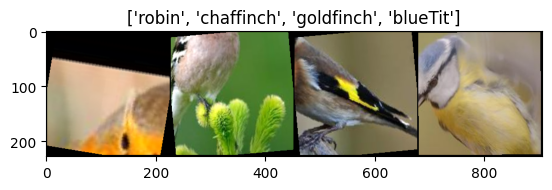

In [30]:
# From lab 5
# Data augmentation transformer
# augmentation_transformer = transforms.Compose([
#         transforms.RandomResizedCrop(224), # Crop the given PIL Image to random size and aspect ratio
#         transforms.RandomHorizontalFlip(0.5), # Horizontally flip the given PIL Image randomly with a given probability.
#         transforms.ColorJitter(brightness=0.1), # Randomly change the brightness, contrast and saturation of an image
#         transforms.RandomRotation(degrees=10), # Rotate the image by angle.
#         transforms.ToTensor()])

# # Same as above, expect that we are using augmentation_transformer instead of simple_transformer
# train_set = datasets.ImageFolder(PATH_TRAIN, augmentation_transformer)
# dataloader_aug = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4)
# inputs, classes = next(iter(dataloader_aug))
# out = torchvision.utils.make_grid(inputs)
# imshow(out, title=[train_set.classes[x] for x in classes])

In [31]:
inputs, classes = next(iter(dataloader_train))

In [47]:
print(classes)

tensor([2, 1, 4, 1])


Import ResNet50 model with the pretrained weights  
https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50

In [75]:
pretrained_weigths = models.ResNet50_Weights.DEFAULT
def load_model(weigths = pretrained_weigths):
    model = resnet50(weights=weigths)
    print(model)
    #Replace last layer to match 7 classes
    model.fc = torch.nn.Linear(model.fc.in_features, 7)
    print(model.fc)
    return model
model = load_model()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [33]:
# Initialize the inference transforms
preprocess = pretrained_weigths.transforms()
# dont know if we need

Inference transforms perform the following preprocessing operations:  
- Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects.  
- The images are resized to resize_size=[232] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224].  
- Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].

Put the pedal to the medal and use GPU

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [52]:
def train_model(model, optimizer, num_epoch=25, batch_size=5):
    acc_train = []
    acc_validation = []
    best_acc = 0.0
    best_model_weight = copy.deepcopy(model.state_dict())

    since = time.time()
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch+1, num_epoch))
        print("-"*10)
        #training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in dataloader_train:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # print("Input " + labels )
            # idk do something

            #zero the parameter gradients 
            optimizer.zero_grad()

            #forward
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                criterion = torch.nn.CrossEntropyLoss()
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss_train = running_loss / dataset_size_train
        epoch_acc_train = running_corrects.double() / dataset_size_train
        acc_train.append(epoch_acc_train)
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_train, epoch_acc_train))

        #validation phase
        model.eval()
        running_loss_val = 0.0
        running_corrects_val = 0
        for inputs, labels in dataloader_validation:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                criterion = torch.nn.CrossEntropyLoss()
                loss = criterion(outputs, labels)
            running_loss_val += loss.item() * inputs.size(0)
            running_corrects_val += torch.sum(preds == labels.data)
        epoch_loss_val = running_loss_val / dataset_size_val
        epoch_acc_val = running_corrects_val.double() / dataset_size_val
        print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_val, epoch_acc_val))
        
        if(epoch_acc_val > best_acc):
            best_acc = epoch_acc_val
            best_model_weight = copy.deepcopy(model.state_dict())
        
        time_epoch_val = time.time() - since           
        print('Epoch time {:.0f}m {:.0f}s'.format(time_epoch_val // 60, time_epoch_val % 60))
        print("-"*10)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Validation accuracies:")
    print(acc_validation)
    model.load_state_dict(best_model_weight)
    return model


In [43]:
# Freeze all layers (i.e., disable training)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze final layer (named fc)
for param in model.fc.parameters():
    param.requires_grad = True

# Put the model on the GPU
model = model.to(device)

#Use stochastic gradient descent and optimize parameters
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [67]:
# Generic function to display predictions for a few images
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure().set_figwidth(12)

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader_validation):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(2, num_images//2, images_so_far)
                ax.axis('off')
                ax.set_title('pred/true: {}/{}'.format(val_set.classes[preds[j]],
                                                       val_set.classes[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [89]:
trained = train_model(model=model,optimizer=optimizer, num_epoch=2) #took like 4 minutes on device

Epoch 1/2
----------
Train Loss: 1.9505 Acc: 0.1401
Val Loss: 1.9658 Acc: 0.1154
Epoch time 4m 45s
Epoch 2/2
----------
Train Loss: 1.9535 Acc: 0.1269
Val Loss: 1.9620 Acc: 0.1058
Epoch time 9m 32s
Training complete in 9m 32s
----------



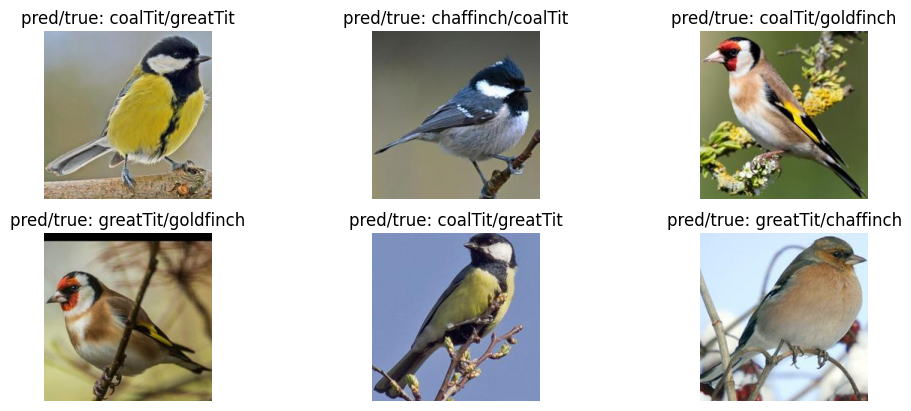

In [90]:
visualize_model(trained)

In [54]:
# Unfreeze all layers
# for param in model.parameters():
#     param.requires_grad = True

# model = train_model(model, optimizer, num_epoch=5) #took like 24 min

Epoch 1/5
----------
Train Loss: 0.3209 Acc: 0.9293
Val Loss: 0.1086 Acc: 0.9904
Epoch time 5m 4s
Epoch 2/5
----------
Train Loss: 0.1382 Acc: 0.9701
Val Loss: 0.0704 Acc: 0.9808
Epoch time 9m 46s
Epoch 3/5
----------
Train Loss: 0.0727 Acc: 0.9856
Val Loss: 0.0529 Acc: 0.9808
Epoch time 14m 48s
Epoch 4/5
----------
Train Loss: 0.0658 Acc: 0.9856
Val Loss: 0.0351 Acc: 1.0000
Epoch time 19m 43s
Epoch 5/5
----------
Train Loss: 0.0528 Acc: 0.9856
Val Loss: 0.0458 Acc: 1.0000
Epoch time 24m 39s
Training complete in 24m 39s
----------



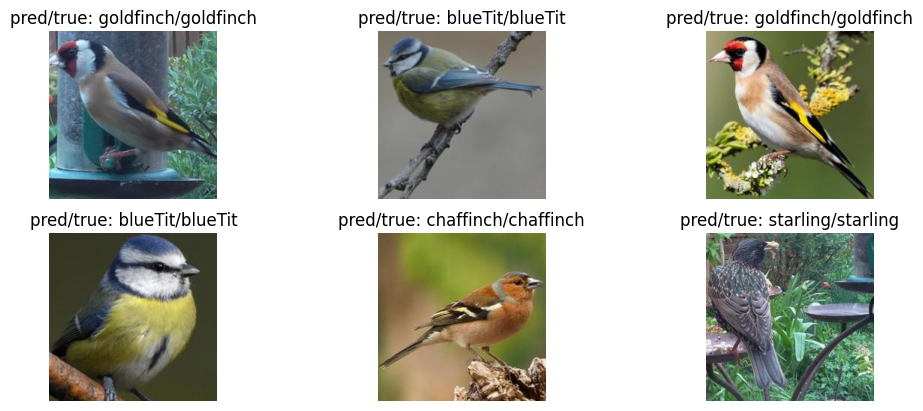

In [68]:
# visualize_model(model)

# # plt.ioff()
# # plt.ion()
# plt.show()

In [103]:

predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloader_validation):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])


# model.eval()
# outputs = model(train_set)
# print(outputs)
# _, preds = torch.max(outputs, 1)
print(lbllist)
# plot_confusion_matrix(predlist.numpy(),lbllist.numpy(), class_labels)

tensor([5, 6, 3, 0, 1, 5, 3, 2, 4, 6, 5, 4, 5, 4, 1, 2, 3, 6, 5, 2, 3, 4, 1, 0,
        0, 6, 6, 6, 5, 2, 5, 0, 1, 3, 4, 0, 3, 3, 0, 1, 2, 6, 1, 1, 3, 4, 5, 5,
        0, 1, 5, 1, 0, 4, 4, 0, 4, 2, 2, 4, 5, 6, 6, 6, 0, 2, 0, 2, 5, 0, 1, 6,
        0, 2, 4, 1, 4, 3, 3, 2, 4, 5, 3, 0, 5, 6, 4, 1, 2, 3, 2, 6, 3, 6, 0, 3,
        6, 1, 3, 5, 1, 1, 2, 4])


In [108]:
print('Shape pred {}'.format(predlist.shape))
print('Shape pred {}'.format(predlist.numpy().shape))
print(lbllist.numpy())
print(predlist.numpy())

Shape pred torch.Size([104])
Shape pred (104,)
[5 6 3 0 1 5 3 2 4 6 5 4 5 4 1 2 3 6 5 2 3 4 1 0 0 6 6 6 5 2 5 0 1 3 4 0 3
 3 0 1 2 6 1 1 3 4 5 5 0 1 5 1 0 4 4 0 4 2 2 4 5 6 6 6 0 2 0 2 5 0 1 6 0 2
 4 1 4 3 3 2 4 5 3 0 5 6 4 1 2 3 2 6 3 6 0 3 6 1 3 5 1 1 2 4]
[2 4 4 1 1 1 4 4 2 2 1 1 5 2 1 5 4 4 4 2 4 1 3 2 2 1 2 2 4 0 4 1 2 4 1 1 4
 1 1 2 4 2 6 2 4 2 1 2 1 4 4 4 1 1 1 4 1 1 1 2 2 2 2 3 4 1 1 4 1 1 1 3 4 5
 4 4 1 4 4 4 2 4 4 4 2 2 2 1 4 4 1 4 4 2 4 2 2 5 4 4 1 1 2 4]


hello world
Shape pred torch.Size([104])
Shape pred (104,)
Shape lbl (104,)
[[ 0  8  2  0  5  0  0]
 [ 0  6  3  1  3  1  1]
 [ 1  4  2  0  5  2  0]
 [ 0  1  1  0 13  0  0]
 [ 0  7  6  0  2  0  0]
 [ 0  4  4  0  6  1  0]
 [ 0  1  9  2  3  0  0]]


<AxesSubplot: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

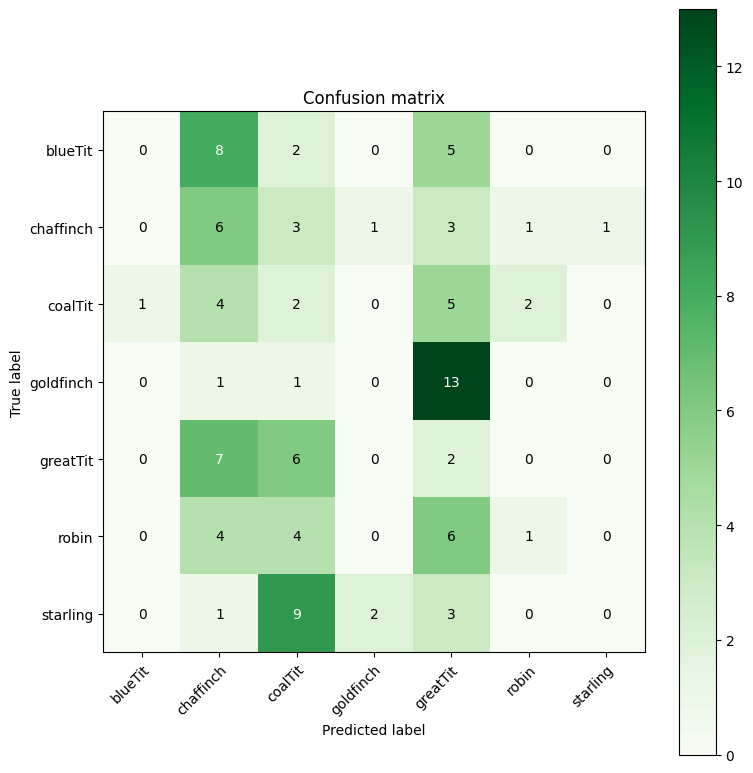

In [110]:
%run stinna.ipynb
plot_confusion_matrix(trained, dataloader_validation, class_labels, device)